In [1]:
import os, sys
sys.path.append('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import MazeEnv.MultiTargetMazeEnv as mz
from Training.Utils import make_circular_map
from TrainingNavigator.StepperAgent import StepperAgent
from MazeEnv.EnvAttributes import Rewards
from Training.Utils import get_multi_targets_circle_envs

# success rate as function of the farthest goal
(with or without random initialization)

In [2]:
targets_loc = np.genfromtxt("workspaces/test_coords_0_6to3.csv", delimiter=',')
num_workspaces = len(targets_loc)
agent_path = "../TrainingNavigator/StepperAgents/TorqueStepperF1500.pt"
agent = StepperAgent(agent_path)

In [3]:
# rewards configuration doesn't matter because we only test
env_no_rand_init, eval_to_delete = get_multi_targets_circle_envs(radius=5,
                                                 target_loc_list=targets_loc,
                                                 test_target_loc_list=[(5,5)],
                                                 show_gui=False,
                                                 hit_target_epsilon=0.25,
                                                 success_steps_before_done=25,
                                                 timeout_steps=200,
                                                 sticky_actions=5,
                                                 xy_in_obs=False,
                                                 noisy_ant_initialization=False)
del eval_to_delete

env_with_rand_init, eval_to_delete = get_multi_targets_circle_envs(radius=5,
                                                 target_loc_list=targets_loc,
                                                 test_target_loc_list=[(5,5)],
                                                 show_gui=False,
                                                 hit_target_epsilon=0.25,
                                                 success_steps_before_done=25,
                                                 timeout_steps=200,
                                                 sticky_actions=5,
                                                 xy_in_obs=False,
                                                 noisy_ant_initialization=True)
del eval_to_delete


In [4]:
def get_per_goal_evaluation(agent, env: mz.MultiTargetMazeEnv):
    """
     return two lists for evaluation, for each list, each goal is a tuple of (distance, is_end_success, is_success_at_all).
     is_end_success means "last step is succesful" which means the robot got to the goal and stayed there at least 25 steps and until the end of the episode
     is_success_at_all is true if the robot got to the goal at least once
     """
    goals = []
    for i in range(num_workspaces):
        distance =  np.linalg.norm(np.array(targets_loc[i]) - np.array([5, 5]))
        is_success_at_all = False
        success_steps_count = 0

        obs = env.reset(target_index=i)
        done = False
        while not done:
            action = agent.step(obs)
            obs, reward, done, info = env.step(action)
            if info['success']:
                is_success_at_all = True
                success_steps_count += 1

        is_end_success = success_steps_count >= 25 and info["success"]
        goals.append((distance, is_end_success ,is_success_at_all))

    return goals

start with no random initialization:

In [5]:
goals_no_random_init = get_per_goal_evaluation(agent, env_no_rand_init)

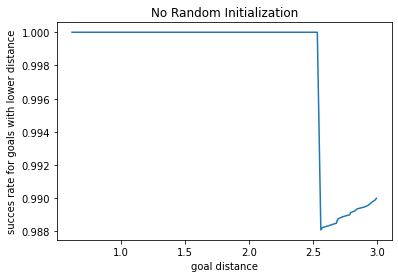

In [6]:
goals_no_random_init.sort(key=lambda tup: tup[0])
distances = np.array([tup[0] for tup in goals_no_random_init])
is_end_success = np.array([tup[1] for tup in goals_no_random_init])
closer_goals_count = np.arange(1, 101)

end_success_lower_than = np.cumsum(is_end_success) / closer_goals_count

plt.plot(distances, end_success_lower_than)
plt.title("No Random Initialization")
plt.xlabel("goal distance")
plt.ylabel("succes rate for goals with lower distance")
plt.show()


now with random initialization. perform multiple experiments per target

In [32]:
success_counts_end = np.zeros(num_workspaces)
success_counts_once = np.zeros(num_workspaces)

episodes_per_goal = 100

for i in range(episodes_per_goal):
    result = get_per_goal_evaluation(agent, env_with_rand_init)
    result.sort(key=lambda tup: tup[0])
    result = np.array(result)
    success_counts_end += result[:, 1]
    success_counts_once += result[:, 2]

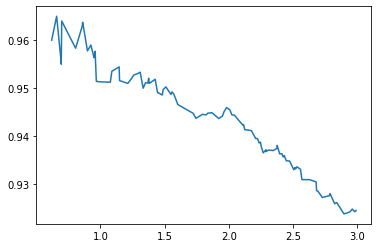

In [33]:
distances = np.array([tup[0] for tup in result])

episodes_count_lower_than = np.arange(1, num_workspaces+1) * episodes_per_goal
end_success_rate_lower_than = np.cumsum(success_counts_end) / episodes_count_lower_than
success_at_all_rate_lower_than = np.cumsum(success_counts_once) / episodes_count_lower_than

plt.plot(distances, success_at_all_rate_lower_than)
plt.show()

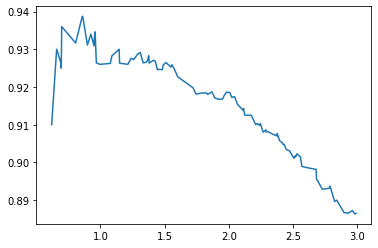

In [34]:
plt.plot(distances, end_success_rate_lower_than)
plt.show()